In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
import xgboost as xgb
import shap
import os

## Load data (Almaty air)

In [28]:
df = pd.read_csv('almaty-air.csv')
df.sort_values(by='date', inplace=True)
df.reset_index(drop=True)
print("Loaded rows:", len(df))
df.head()

Loaded rows: 1631


,date,pm25,pm10,no2,so2,co
1123,2020/10/1,73,,,,
1132,2020/10/10,75,,,,
1133,2020/10/11,92,,,,
1134,2020/10/12,104,,,,
1135,2020/10/13,92,,,,


In [29]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1631 entries, 1123 to 8
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1631 non-null   object
 1    pm25   1631 non-null   object
 2    pm10   1631 non-null   object
 3    no2    1631 non-null   object
 4    so2    1631 non-null   object
 5    co     1631 non-null   object
dtypes: object(6)
memory usage: 89.2+ KB


,date,pm25,pm10,no2,so2,co
count,1631,1631,1631,1631,1631,1631
unique,1631,201,150,70,18,35
top,2020/10/1,,,,1,
freq,1,192,351,701,994,277


## Cleaning data

In [30]:
pollutants = [' pm25', ' pm10', ' no2', ' so2', ' co']
for col in pollutants:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].rolling(window=3, min_periods=1).mean())
    df[col] = df[col].fillna(df[col].median())
if 'AQI' in df.columns:
    df['AQI'] = pd.to_numeric(df['AQI'], errors='coerce')
    df['AQI'] = df['AQI'].fillna(df['AQI'].rolling(window=3, min_periods=1).mean())
    df['AQI'] = df['AQI'].fillna(df['AQI'].median())

## Lags and rolling stats

In [31]:
def add_lag_features(df, cols, lags=[1,24,168]):
    for c in cols:
        for l in lags:
            df[f'{c}_lag_{l}'] = df[c].shift(l)
    return df

def add_roll_features(df, cols, windows=[3,7]):
    for c in cols:
        for w in windows:
            df[f'{c}_roll_mean_{w}'] = df[c].rolling(window=w, min_periods=1).mean()
    return df

cols_to_process = [' pm25', ' pm10', ' no2', ' so2', ' co']
if 'AQI' in df.columns:
    cols_to_process.append('AQI')

df = add_lag_features(df, cols_to_process, lags=[1,24])
df = add_roll_features(df, cols_to_process, windows=[3,7])

In [32]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek
df['hour'] = df['date'].dt.hour

df = df.dropna().reset_index(drop=True)
print("After lag/roll processing and dropping NaNs rows:", len(df))

After lag/roll processing and dropping NaNs rows: 1607


/var/folders/gk/k0653ybj3pz67w5c5_853mvw0000gn/T/ipykernel_23690/1299073715.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 800x600 with 0 Axes>

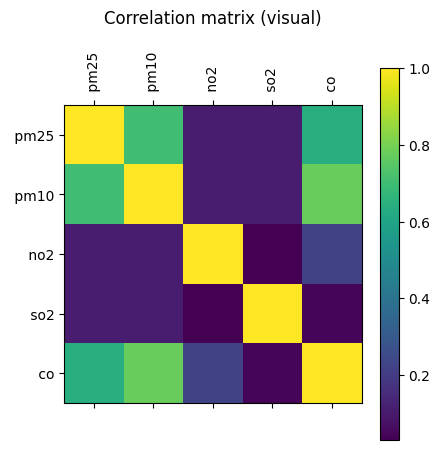

In [33]:
corr_cols = pollutants + ['temperature','humidity','wind_speed','AQI']
corr_cols = [c for c in corr_cols if c in df.columns]
corr = df[corr_cols].corr()


plt.figure(figsize=(8,6))
plt.matshow(corr)
plt.title('Correlation matrix (visual)', pad=20)
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.colorbar()
plt.tight_layout()
plt.show()

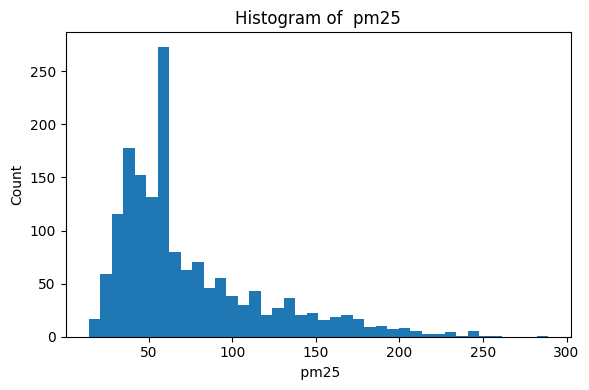

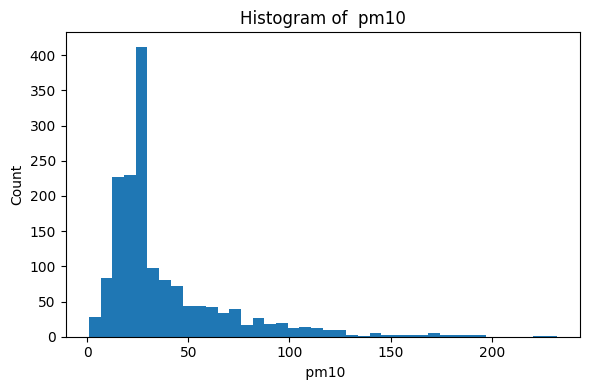

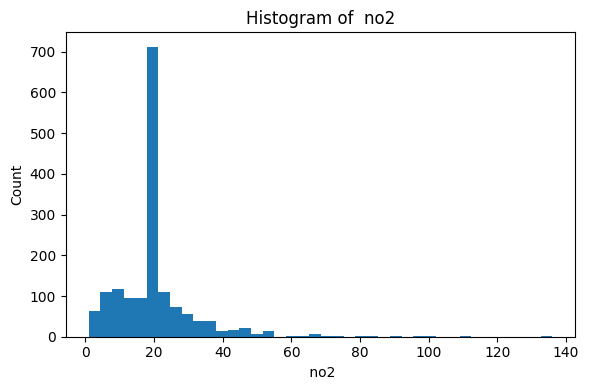

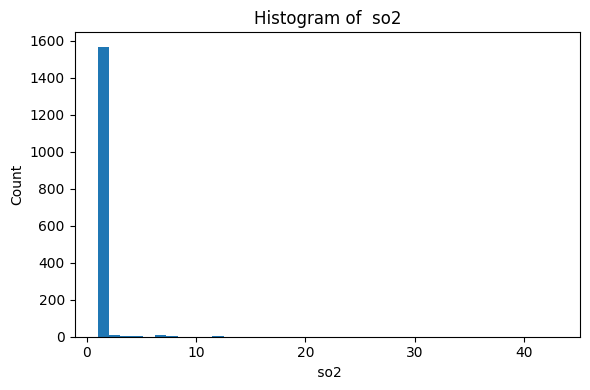

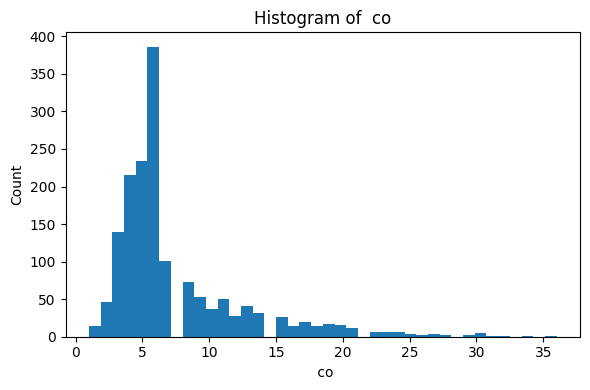

In [34]:
for p in pollutants:
    plt.figure(figsize=(6,4))
    plt.hist(df[p].dropna(), bins=40)
    plt.xlabel(p)
    plt.ylabel('Count')
    plt.title(f'Histogram of {p}')
    plt.tight_layout()
    plt.show()

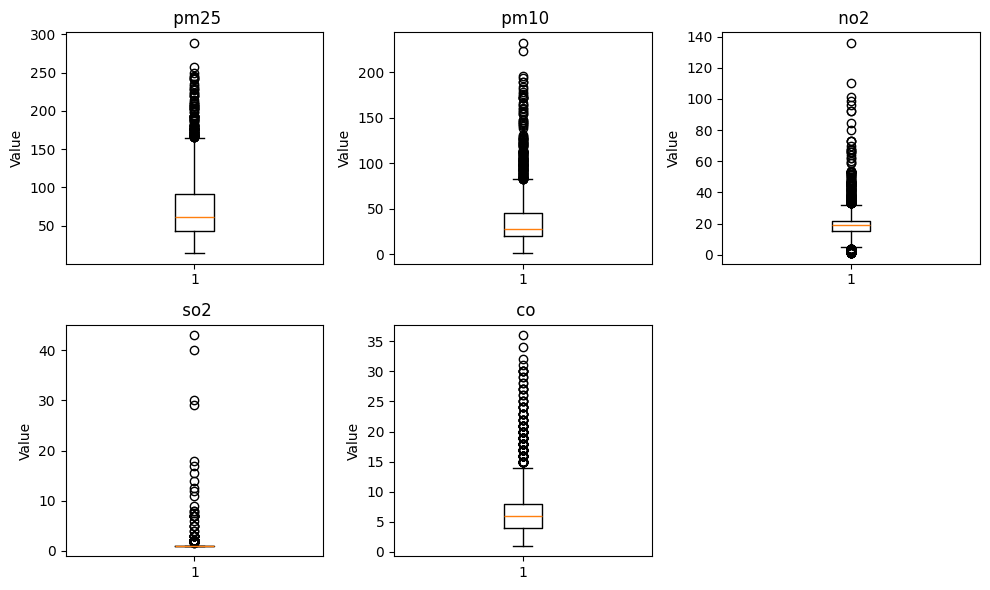

In [35]:
plt.figure(figsize=(10,6))
for i, p in enumerate(pollutants):
    ax = plt.subplot(2, 3, i+1)
    ax.boxplot(df[p].dropna())
    ax.set_title(p)
    ax.set_ylabel('Value')
plt.tight_layout()
plt.show()

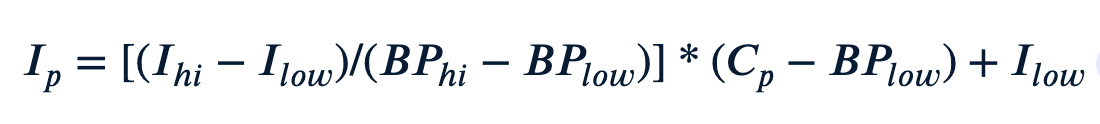


## Formula to calculate AQI


In [36]:
def calculate_aqi_pm25(pm25):
    breakpoints = [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 350.4, 301, 400),
        (350.5, 500.4, 401, 500)
    ]

    for bp_low, bp_hi, i_low, i_hi in breakpoints:
        if bp_low <= pm25 <= bp_hi:
            aqi = ((i_hi - i_low) / (bp_hi - bp_low)) * (pm25 - bp_low) + i_low
            return aqi
    return 500.0

df['AQI'] = df[' pm25'].apply(calculate_aqi_pm25)

print("DataFrame with AQI column calculated using the specified formula:")
display(df.head())

DataFrame with AQI column calculated using the specified formula:


,date,pm25,pm10,no2,so2,co,pm25_lag_1,pm25_lag_24,pm10_lag_1,pm10_lag_24,...,no2_roll_mean_3,no2_roll_mean_7,so2_roll_mean_3,so2_roll_mean_7,co_roll_mean_3,co_roll_mean_7,month,dayofweek,hour,AQI
0,2020-10-04,56.0,28.0,19.0,1.0,6.0,103.0,73.0,28.0,28.0,...,19.0,19.0,1.0,1.0,6.0,6.0,10,6,0,151.258166
1,2020-10-05,52.0,28.0,19.0,1.0,6.0,56.0,75.0,28.0,28.0,...,19.0,19.0,1.0,1.0,6.0,6.0,10,0,0,141.628141
2,2020-10-06,53.0,28.0,19.0,1.0,6.0,52.0,92.0,28.0,28.0,...,19.0,19.0,1.0,1.0,6.0,6.0,10,1,0,144.090452
3,2020-10-07,77.0,28.0,19.0,1.0,6.0,53.0,104.0,28.0,28.0,...,19.0,19.0,1.0,1.0,6.0,6.0,10,2,0,162.101159
4,2020-10-08,78.0,28.0,19.0,1.0,6.0,77.0,92.0,28.0,28.0,...,19.0,19.0,1.0,1.0,6.0,6.0,10,3,0,162.617492


/var/folders/gk/k0653ybj3pz67w5c5_853mvw0000gn/T/ipykernel_23690/118252263.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 800x500 with 0 Axes>

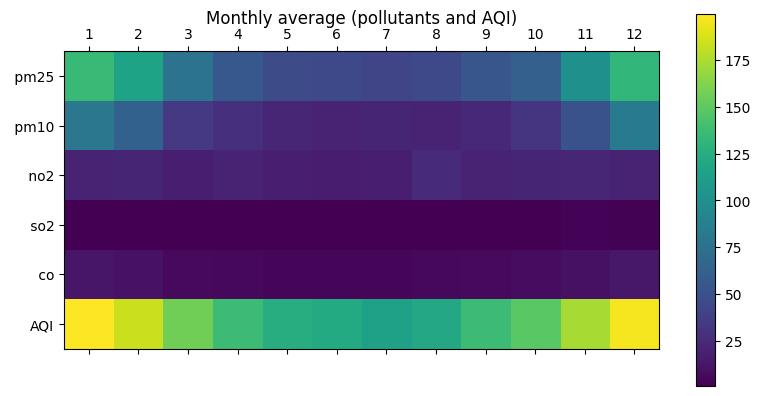

In [37]:
monthly = df.groupby(df['date'].dt.month)[pollutants + ['AQI']].mean().reindex(range(1,13)).fillna(0)
plt.figure(figsize=(8,5))
plt.matshow(monthly.T)
plt.title('Monthly average (pollutants and AQI)', pad=20)
plt.xticks(range(12), range(1,13))
plt.yticks(range(monthly.shape[1]), monthly.columns)
plt.colorbar()
plt.tight_layout()
plt.show()

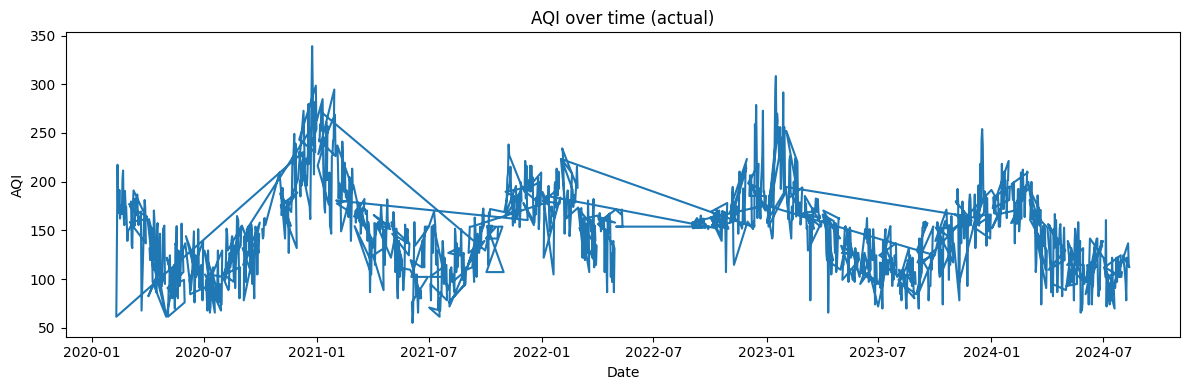

In [38]:
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['AQI'])
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('AQI over time (actual)')
plt.tight_layout()
plt.show()

## Naive prediction

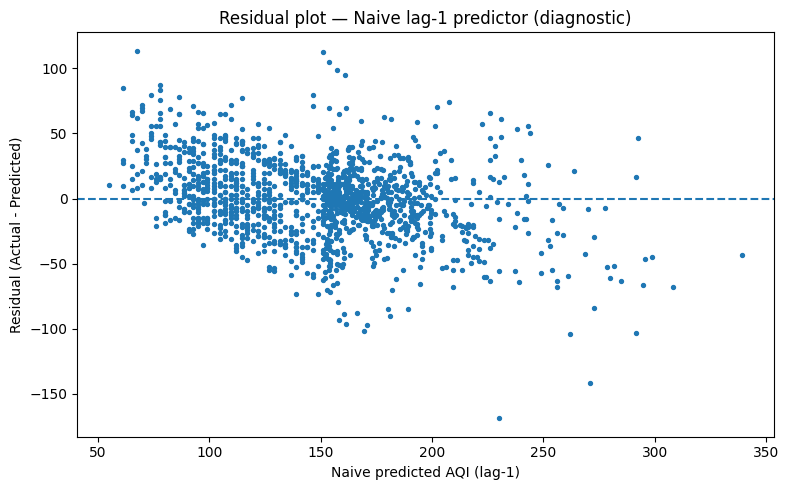

In [39]:
df['AQI_lag1'] = df['AQI'].shift(1)
df_clean = df.dropna().reset_index(drop=True)
n = len(df_clean)
pred_naive = df_clean['AQI_lag1'].values
actual = df_clean['AQI'].values
residuals = actual - pred_naive

plt.figure(figsize=(8,5))
plt.scatter(pred_naive, residuals, s=8)
plt.axhline(0, linestyle='--')
plt.xlabel('Naive predicted AQI (lag-1)')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual plot — Naive lag-1 predictor (diagnostic)')
plt.tight_layout()
plt.show()

## Define X, y (regression)

In [40]:
target = 'AQI'
features = [c for c in df.columns if c not in ['date', 'city', 'AQI']]

split_ratio = 0.8
split_idx = int(len(df) * split_ratio)

X = df[features]
y = df[target]

X_train, y_train = X.iloc[:split_idx], y.iloc[:split_idx]
X_test, y_test = X.iloc[split_idx:], y.iloc[split_idx:]

train_data = pd.concat([X_train, y_train], axis=1).dropna()
X_train = train_data[features]
y_train = train_data[target]

print("X_train shape after dropping NaNs:", X_train.shape)
print("y_train shape after dropping NaNs:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape after dropping NaNs: (1284, 29)
y_train shape after dropping NaNs: (1284,)
X_test shape: (322, 29)
y_test shape: (322,)


## Scaling

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Linear Regression

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

print("LinearReg MAE:", mean_absolute_error(y_test, y_pred))
print("LinearReg RMSE:", mean_squared_error(y_test, y_pred)**0.5)
print("R2:", r2_score(y_test, y_pred))

LinearReg MAE: 10.860880411929937
LinearReg RMSE: 13.280816742816782
R2: 0.8644988388317143


## Random forest

In [ ]:
import joblib

rf = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print("RF MAE:", mean_absolute_error(y_test, pred_rf))
print("RF RMSE:", mean_squared_error(y_test, pred_rf)**0.5)
print("R2:", r2_score(y_test, pred_rf))
joblib.dump(rf, 'rf_aqi_model.pkl')

RF MAE: 0.05281777547767739
RF RMSE: 0.12943820230408656
R2: 0.9999871288191058


 pm25                0.999135
 no2_lag_1           0.000137
 co_roll_mean_3      0.000093
 no2_roll_mean_3     0.000093
 pm25_roll_mean_3    0.000065
 pm25_lag_1          0.000064
 no2                 0.000053
AQI_lag1             0.000039
 pm10_lag_1          0.000036
 co_lag_24           0.000034
 so2_roll_mean_7     0.000034
 pm10_roll_mean_7    0.000026
 pm10_roll_mean_3    0.000025
 co_lag_1            0.000021
 so2                 0.000020
dayofweek            0.000019
 no2_roll_mean_7     0.000017
 pm10                0.000014
 no2_lag_24          0.000013
 pm25_lag_24         0.000012
dtype: float64


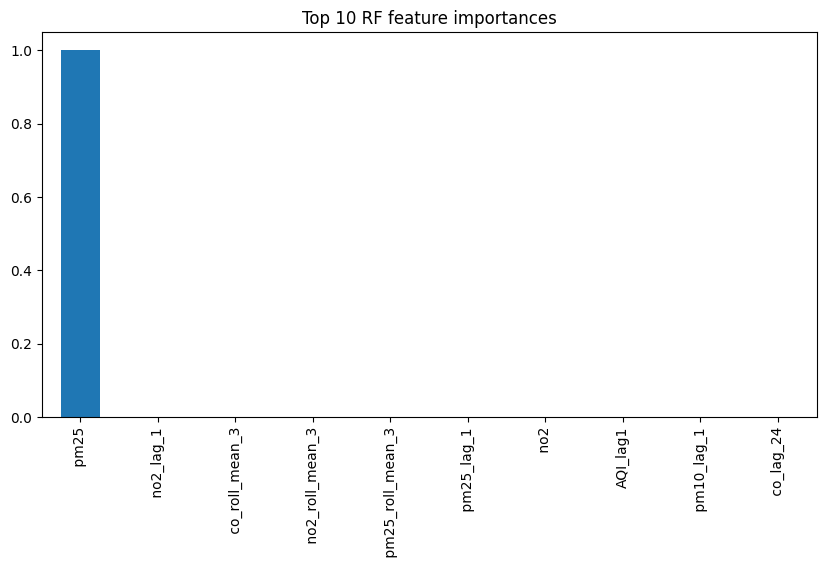

In [44]:
fi = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(fi.head(20))
fi.head(10).plot(kind='bar', figsize=(10,5))
plt.title('Top 10 RF feature importances')
plt.show()

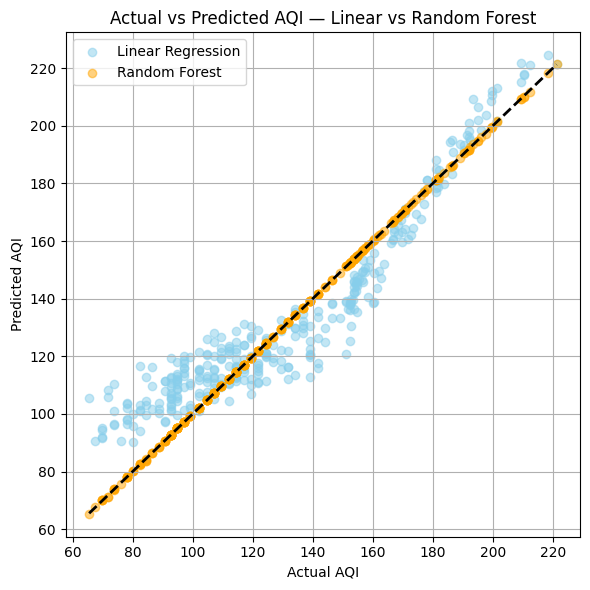

In [45]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Linear Regression", color='skyblue')
plt.scatter(y_test, pred_rf, alpha=0.5, label="Random Forest", color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI — Linear vs Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##  XGBoost Regressor

In [46]:
xgbr = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42, tree_method='approx')
xgbr.fit(X_train, y_train, eval_set=[(X_test, y_test)])
pred_xgb = xgbr.predict(X_test)
print("XGB MAE:", mean_absolute_error(y_test, pred_xgb))
print("XGB RMSE:", mean_squared_error(y_test, pred_xgb)**0.5)
print("R2:", r2_score(y_test, pred_xgb))

[0]	validation_0-rmse:41.67195
[1]	validation_0-rmse:39.60780
[2]	validation_0-rmse:37.63155
[3]	validation_0-rmse:35.76620
[4]	validation_0-rmse:34.02283
[5]	validation_0-rmse:32.34215
[6]	validation_0-rmse:30.72574
[7]	validation_0-rmse:29.21425
[8]	validation_0-rmse:27.79841
[9]	validation_0-rmse:26.43948
[10]	validation_0-rmse:25.13126
[11]	validation_0-rmse:23.87921
[12]	validation_0-rmse:22.69443
[13]	validation_0-rmse:21.57144
[14]	validation_0-rmse:20.50620
[15]	validation_0-rmse:19.48648
[16]	validation_0-rmse:18.52950
[17]	validation_0-rmse:17.62094
[18]	validation_0-rmse:16.74202
[19]	validation_0-rmse:15.91745
[20]	validation_0-rmse:15.11591
[21]	validation_0-rmse:14.38271
[22]	validation_0-rmse:13.67325
[23]	validation_0-rmse:12.98748
[24]	validation_0-rmse:12.34503
[25]	validation_0-rmse:11.72961
[26]	validation_0-rmse:11.14573
[27]	validation_0-rmse:10.60134
[28]	validation_0-rmse:10.07824
[29]	validation_0-rmse:9.58230
[30]	validation_0-rmse:9.10841
[31]	validation_0-rm

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score

Xtr_t = torch.tensor(X_train_scaled, dtype=torch.float32)
ytr_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
Xte_t = torch.tensor(X_test_scaled, dtype=torch.float32)

class DLinear(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.fc = nn.Linear(in_dim, 1)

    def forward(self, x):
        return self.fc(x)

dlinear_model = DLinear(X_train_scaled.shape[1])
optimizer = optim.Adam(dlinear_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

for epoch in range(500):
    optimizer.zero_grad()
    pred = dlinear_model(Xtr_t)
    loss = criterion(pred, ytr_t)
    loss.backward()
    optimizer.step()

pred_dlinear = dlinear_model(Xte_t).detach().numpy().flatten()

print("MAE :", mean_absolute_error(y_test, pred_dlinear))
print("RMSE:", mean_squared_error(y_test, pred_dlinear) ** 0.5)
print("R²  :", r2_score(y_test, pred_dlinear))


MAE : 144.1810343356601
RMSE: 145.75909621120064
R²  : -15.32167712044349


In [ ]:
!pip install sklearn-genetic-opt -q

from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    "n_estimators": Integer(100, 500),
    "max_depth": Integer(4, 20),
    "min_samples_split": Integer(2, 10)
}

rf_base = RandomForestRegressor(random_state=42)

ga = GASearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    population_size=20,
    generations=8,
    n_jobs=-1,
    verbose=True
)

ga.fit(X_train, y_train)
pred_ga = ga.best_estimator_.predict(X_test)

print("Best params:", ga.best_params_)
print("MAE :", mean_absolute_error(y_test, pred_ga))
print("RMSE:", mean_squared_error(y_test, pred_ga)**0.5)
print("R²  :", r2_score(y_test, pred_dlinear))

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

estimators = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42)),
    ('xgb', xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='reg:squarederror',
        random_state=42
    )),
    ('lr', LinearRegression())
]

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV()
)

stack.fit(X_train, y_train)
pred_stack = stack.predict(X_test)

print("=== STACKING MODEL ===")
print("MAE :", mean_absolute_error(y_test, pred_stack))
print("RMSE:", mean_squared_error(y_test, pred_stack)**0.5)
print("R²  :", r2_score(y_test, pred_dlinear))


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

results = {
    "Linear Regression": pred_lr if 'pred_lr' in globals() else None,
    "Random Forest": pred_rf if 'pred_rf' in globals() else None,
    "XGBoost": pred_xgb if 'pred_xgb' in globals() else None,
    "GA Optimized RF": pred_ga if 'pred_ga' in globals() else None,
    "Stacking": pred_stack if 'pred_stack' in globals() else None,
    "Transformer (DLinear)": pred_dlinear if 'pred_dlinear' in globals() else None,
    "Transfer Learning": pred_tl if 'pred_tl' in globals() else None,
}

metrics = {"Model": [], "MAE": [], "RMSE": [], "R²": []}

for model, pred in results.items():
    if pred is None:
        continue
    metrics["Model"].append(model)
    metrics["MAE"].append(mean_absolute_error(y_test, pred))
    metrics["RMSE"].append(mean_squared_error(y_test, pred)**0.5)
    metrics["R²"].append(r2_score(y_test, pred))

df_metrics = pd.DataFrame(metrics)
df_metrics = df_metrics.sort_values("RMSE")  # Best models at top

print("=== FINAL MODEL COMPARISON TABLE ===")
display(df_metrics)


plt.figure(figsize=(10, 6))
plt.barh(df_metrics["Model"], df_metrics["RMSE"])
plt.xlabel("RMSE (Lower = Better)")
plt.title("Model Performance Comparison")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()


## SHAP explainability
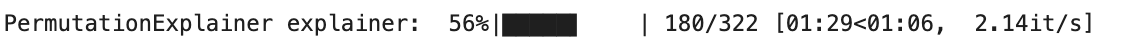

In [ ]:
explainer = shap.Explainer(lambda x: xgbr.predict(x), X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, show=True)

## Convert regression → classification

In [ ]:
def aqi_to_category(aqi):
    if aqi <= 50: return "Good"
    if aqi <= 100: return "Moderate"
    if aqi <= 150: return "Unhealthy for Sensitive"
    if aqi <= 200: return "Unhealthy"
    if aqi <= 300: return "Very Unhealthy"
    return "Hazardous"

y_class = y.apply(aqi_to_category)
y_train_class = y_class.iloc[:split_idx]
y_test_class = y_class.iloc[split_idx:]

## Train a RF classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)

# Ensure y_train_class has the same index as X_train after dropping NaNs
y_train_class_cleaned = y_class.loc[X_train.index]

clf.fit(X_train, y_train_class_cleaned)
pred_clf = clf.predict(X_test)
print("Classification report:\n", classification_report(y_test_class, pred_clf))
cm = confusion_matrix(y_test_class, pred_clf, labels=np.unique(y_test_class))
print("Confusion matrix:\n", cm)

In [ ]:
import joblib
joblib.dump(rf, 'rf_aqi_model.pkl')
joblib.dump(xgbr, 'xgb_aqi_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

In [ ]:
monthly_aqi = df.groupby(df['date'].dt.to_period('M'))['AQI'].mean()
plt.figure(figsize=(10,4))
plt.plot(monthly_aqi.index.to_timestamp(), monthly_aqi.values)
plt.xlabel('Month')
plt.ylabel('Average AQI')
plt.title('Monthly average AQI (trend)')
plt.tight_layout()
plt.show()